In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sfumato.utils.visualizer import plot_signal_analysis

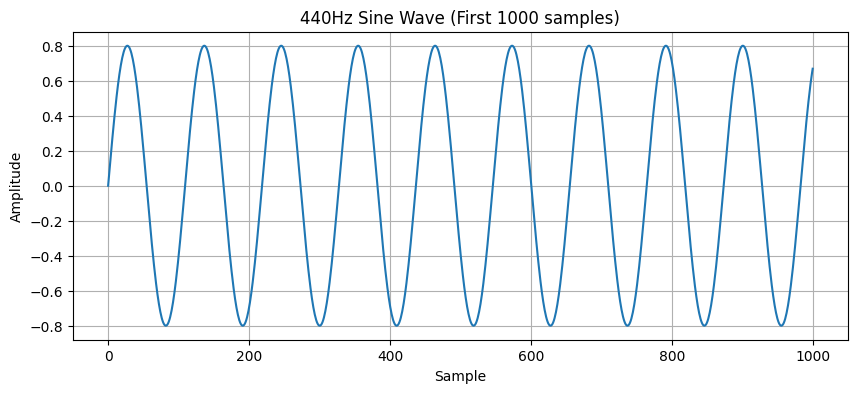

In [3]:
from sfumato.utils.audio_source import AudioSource

# インスタンス化 (48kHz)
source = AudioSource(sample_rate=48000)

# パターンA: 440Hz (A4) の音を 0.1秒作る
tone_data = source.sine_tone(frequency=440.0, duration=0.1)

plt.figure(figsize=(10, 4))
plt.plot(tone_data[:1000])  # 最初の1000サンプルだけ表示
plt.title("440Hz Sine Wave (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

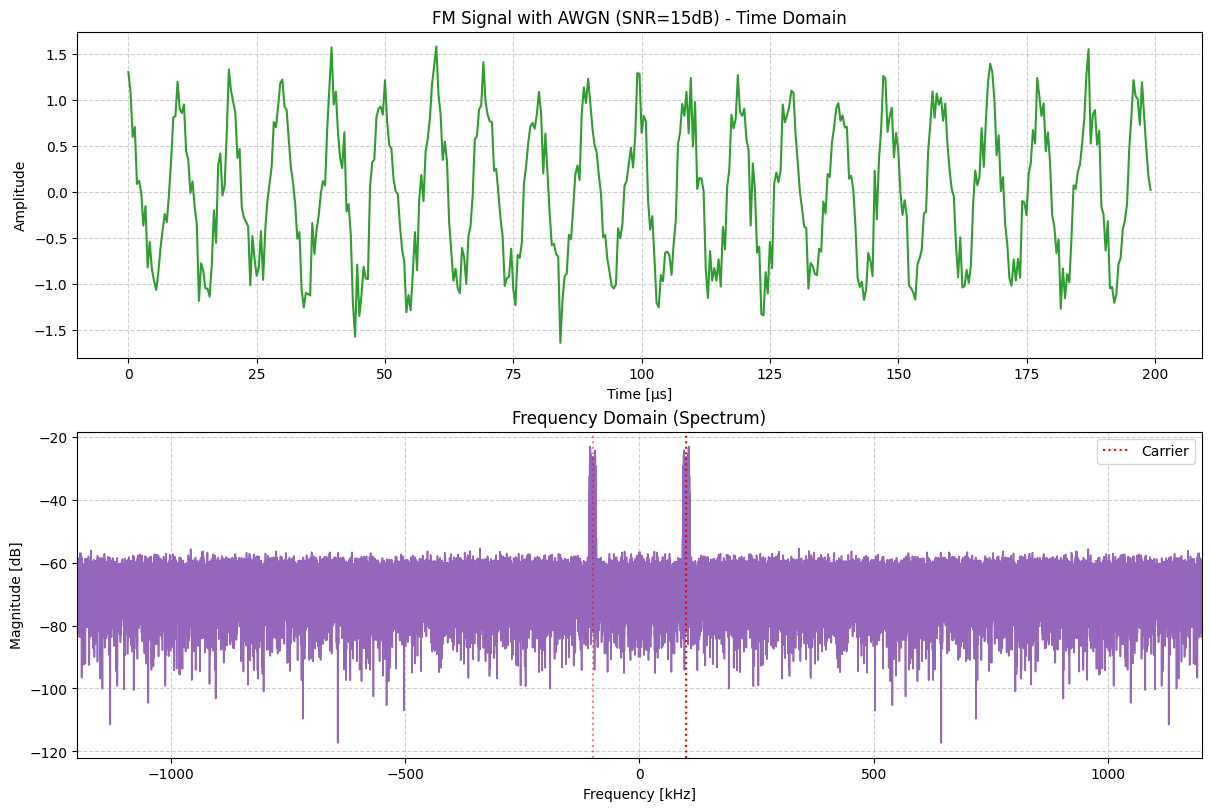

In [4]:
from sfumato import transmitter
from sfumato.channnel import add_awgn

tx = transmitter.FmTransmitter()
signal_clean = tx.modulate(tone_data)
signal_noisy = add_awgn(signal_clean, snr_db=10.0)

plot_signal_analysis(
    signal_noisy,
    fs=tx.rf_fs,
    title="FM Signal with AWGN (SNR=15dB)",
    zoom_usec=200,  # 200マイクロ秒だけ拡大して見る
    carrier_freq=tx.fc,  # 100kHzの場所に赤線を入れる
)

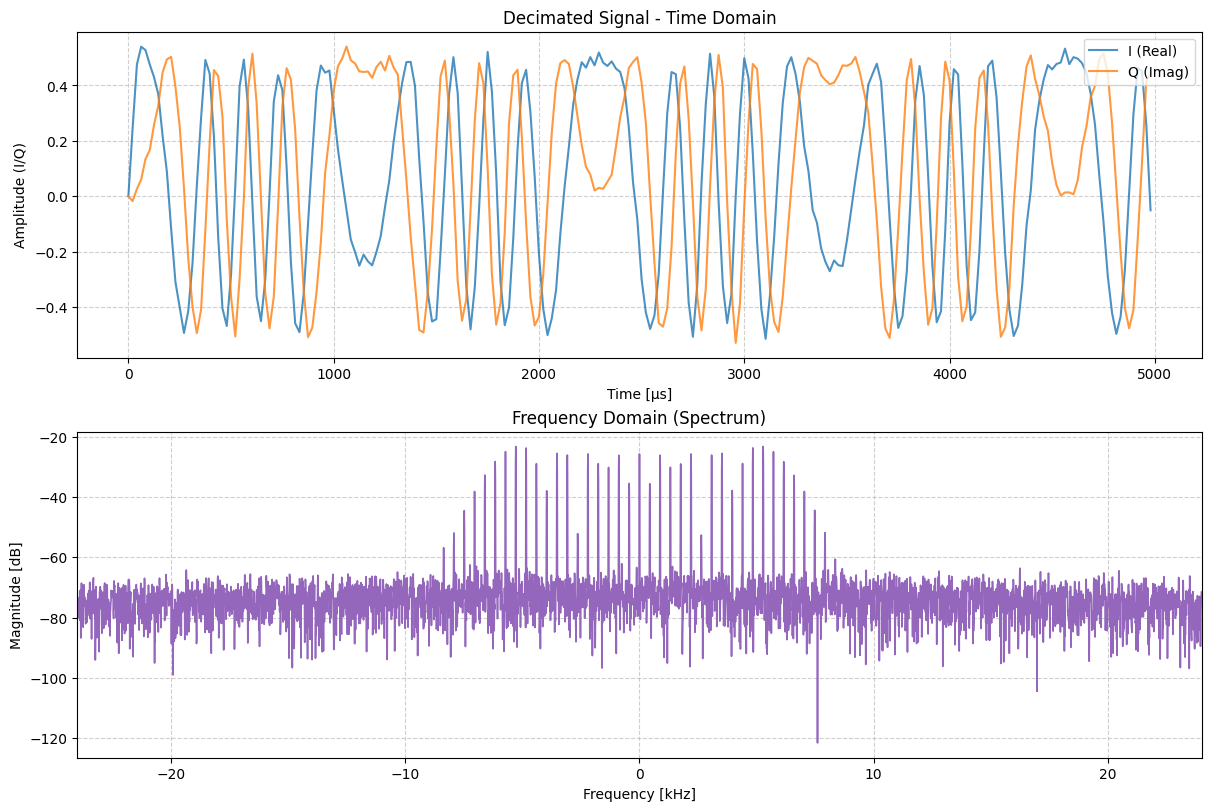

In [6]:
from sfumato import reciever

rx = reciever.FmReceiver()

decimated_iq = rx.process(signal_noisy)
plot_signal_analysis(
    decimated_iq, 
    fs=rx.audio_fs,
    title="Decimated Signal",
    zoom_usec=5000,
    xlim_freq=[-24, 24]
)